In [1]:
import numpy as np

maze = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
])  # 0 = path, 1 = wall

start = (1, 1)
goal = (4, 3)

class MazeEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.pos = start
        return self._get_state()

    def step(self, action):
        move = [(-1,0), (1,0), (0,-1), (0,1)][action]
        new_pos = (self.pos[0]+move[0], self.pos[1]+move[1])
        if maze[new_pos] == 0:
            self.pos = new_pos
        done = (self.pos == goal)
        reward = 1.0 if done else -0.01
        return self._get_state(), reward, done

    def _get_state(self):
        state = np.zeros_like(maze)
        state[self.pos] = 1
        return state.flatten()

env = MazeEnv()


In [3]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.7 MB/s eta 0:00:00


In [16]:
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.functional as SF

class SNNAgent(nn.Module):
    def __init__(self, in_dim, hid_dim=16, out_dim=4, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x, steps=10):
        batch_size = x.shape[0]
        device = x.device  # ensure correct device

        spk2_sum = torch.zeros(batch_size, 4, device=device)

        mem1 = self.lif1.init_leaky()  # no batch arg
        mem2 = self.lif2.init_leaky()

        mem1 = mem1.to(device).repeat(batch_size, 1)
        mem2 = mem2.to(device).repeat(batch_size, 1)

        for _ in range(steps):
            cur = self.fc1(x)
            spk1, mem1 = self.lif1(cur, mem1)
            cur = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur, mem2)
            spk2_sum += spk2

        return spk2_sum





In [20]:
def stdp_update(pre, post, weights, lr=0.01):
    print("pre:", pre.shape, "post:", post.shape, "weights:", weights.shape)
    dw = lr * (pre.T @ post)  # shape: [input_dim, hidden_dim]
    weights.data += dw.T  # transpose to match [hidden_dim, input_dim]
    weights.data.clamp_(0, 1)


model = SNNAgent(in_dim=maze.size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SNNAgent(
  (fc1): Linear(in_features=30, out_features=16, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (lif2): Leaky()
)

In [21]:
import torch.nn.functional as F

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
episodes = 100
max_steps = 30

for ep in range(episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # Prepare input
        x = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        # Forward through SNN
        out_spikes = model(x, steps=10)
        action = torch.argmax(out_spikes).item()

        # Take action in environment
        next_state, reward, done = env.step(action)

        # STDP-like update (unsupervised)
        out = model.fc1(x)
        spikes = F.relu(out) > 0  # crude spike detection
        stdp_update(x, spikes.float(), model.fc1.weight)

        state = next_state
        total_reward += reward
        if done:
            break

    print(f"Episode {ep+1}, Total reward: {total_reward:.2f}")


pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) post: torch.Size([1, 16]) weights: torch.Size([16, 30])
pre: torch.Size([1, 30]) pos

In [22]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.functional as SF
import torch.nn.functional as F

# Maze environment (simple)
from collections import namedtuple

GridState = namedtuple("GridState", ["x", "y"])

class SimpleMazeEnv:
    def __init__(self, size=4):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = GridState(0, 0)
        self.goal_pos = GridState(self.size - 1, self.size - 1)
        return self._get_obs()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0 and y > 0:     y -= 1  # UP
        elif action == 1 and x < self.size - 1: x += 1  # RIGHT
        elif action == 2 and y < self.size - 1: y += 1  # DOWN
        elif action == 3 and x > 0:     x -= 1  # LEFT
        self.agent_pos = GridState(x, y)
        done = self.agent_pos == self.goal_pos
        reward = 1.0 if done else -0.01  # Small penalty to encourage fast path
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        pos = self.agent_pos
        return pos.y * self.size + pos.x  # flatten position into 0-15 state index

    def render(self):
        grid = [["." for _ in range(self.size)] for _ in range(self.size)]
        grid[self.goal_pos.y][self.goal_pos.x] = "G"
        grid[self.agent_pos.y][self.agent_pos.x] = "A"
        for row in grid:
            print(" ".join(row))
        print()


# SNN Encoder: One-hot to spikes
class StateEncoder(nn.Module):
    def __init__(self, n_states):
        super().__init__()
        self.n_states = n_states

    def forward(self, state):
        x = torch.zeros((1, self.n_states), device=device)
        x[0, state] = 1.0
        return x


# SNN Model
class MazeSNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=0.9)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.lif2 = snn.Leaky(beta=0.9)

    def forward(self, x, steps=10):
        batch_size = x.shape[0]
        device = x.device
        spk2_sum = torch.zeros(batch_size, 4, device=device)
        mem1 = self.lif1.init_leaky().to(device).repeat(batch_size, 1)
        mem2 = self.lif2.init_leaky().to(device).repeat(batch_size, 1)

        for _ in range(steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_sum += spk2

        return spk2_sum


# Reward-modulated STDP
def reward_modulated_stdp(pre, post, weights, reward, lr=0.01):
    # Hebbian with reward modulation
    dw = reward * (pre.T @ post)
    weights.data += lr * dw.T  # shape correction
    weights.data.clamp_(0, 1)


# 🔧 Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = SimpleMazeEnv(size=4)
n_states = env.size * env.size
n_actions = 4
hidden_dim = 32

encoder = StateEncoder(n_states).to(device)
model = MazeSNN(n_states, hidden_dim, n_actions).to(device)

# 🔁 Training
episodes = 200
max_steps = 30

for ep in range(1, episodes + 1):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        x = encoder(state)
        out_spikes = model(x, steps=10)
        action = torch.argmax(out_spikes).item()

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # crude spike detection for STDP
        out = model.fc1(x)
        spikes = (F.relu(out) > 0).float()

        reward_modulated_stdp(x, spikes, model.fc1.weight, reward, lr=0.01)
        state = next_state

        if done:
            break

    if ep % 10 == 0:
        print(f"Episode {ep}, Total reward: {total_reward:.2f}")


Episode 10, Total reward: -0.30
Episode 20, Total reward: -0.30
Episode 30, Total reward: -0.30
Episode 40, Total reward: -0.30
Episode 50, Total reward: -0.30
Episode 60, Total reward: -0.30
Episode 70, Total reward: -0.30
Episode 80, Total reward: -0.30
Episode 90, Total reward: -0.30
Episode 100, Total reward: -0.30
Episode 110, Total reward: -0.30
Episode 120, Total reward: -0.30
Episode 130, Total reward: -0.30
Episode 140, Total reward: -0.30
Episode 150, Total reward: -0.30
Episode 160, Total reward: -0.30
Episode 170, Total reward: -0.30
Episode 180, Total reward: -0.30
Episode 190, Total reward: -0.30
Episode 200, Total reward: -0.30


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class SimpleMazeEnv:
    def __init__(self, size=(4, 4), goal=(3, 3)):
        self.size = size
        self.goal = goal
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        return self.get_state()

    def step(self, action):
        x, y = self.agent_pos
        if action == 0 and x > 0:       # up
            x -= 1
        elif action == 1 and x < self.size[0] - 1:  # down
            x += 1
        elif action == 2 and y > 0:     # left
            y -= 1
        elif action == 3 and y < self.size[1] - 1:  # right
            y += 1

        self.agent_pos = [x, y]
        done = (self.agent_pos == list(self.goal))
        reward = 1.0 if done else -0.01
        return self.get_state(), reward, done, {}

    def get_state(self):
        idx = self.agent_pos[0] * self.size[1] + self.agent_pos[1]
        return idx

    def render(self):
        maze = np.zeros(self.size)
        x, y = self.agent_pos
        gx, gy = self.goal

        fig, ax = plt.subplots()
        ax.set_xticks(np.arange(self.size[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(self.size[0] + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linewidth=1)
        ax.tick_params(which="minor", size=0)
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw goal
        goal_patch = patches.Rectangle((gy - 0.5, self.size[0] - gx - 1 - 0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='green')
        ax.add_patch(goal_patch)

        # Draw agent
        agent_patch = patches.Circle((y, self.size[0] - x - 1), 0.3, color='blue')
        ax.add_patch(agent_patch)

        plt.show()


🔁 Agent moving through maze...


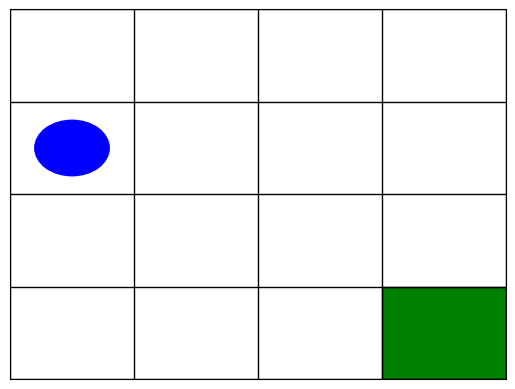

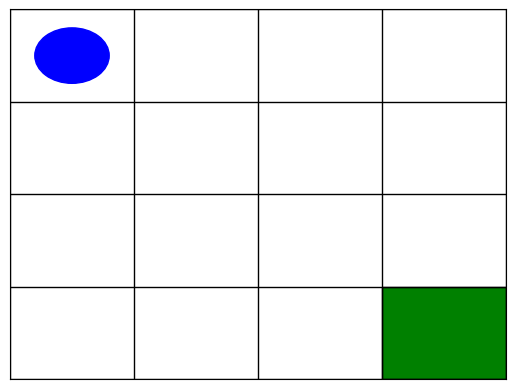

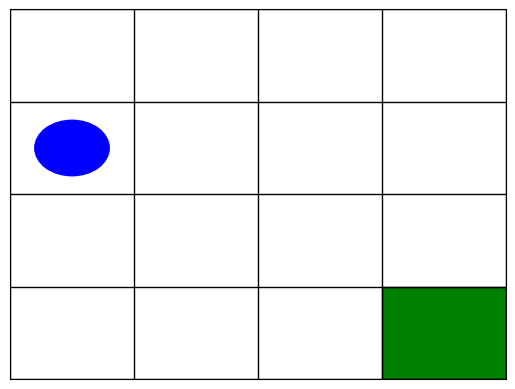

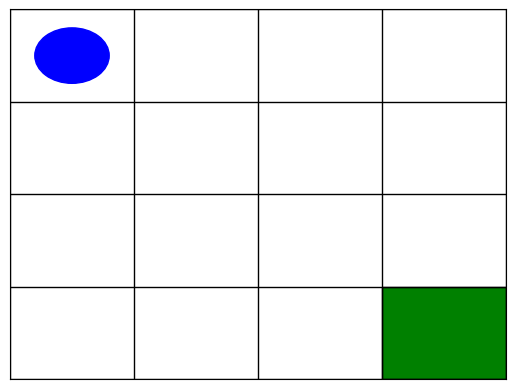

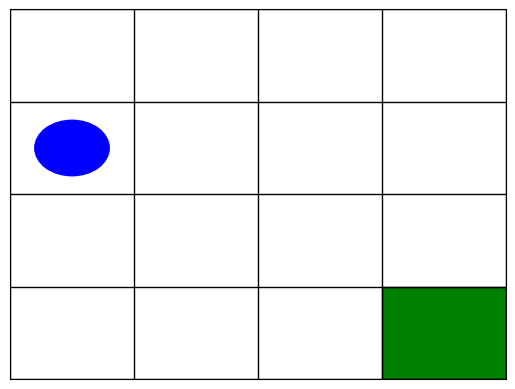

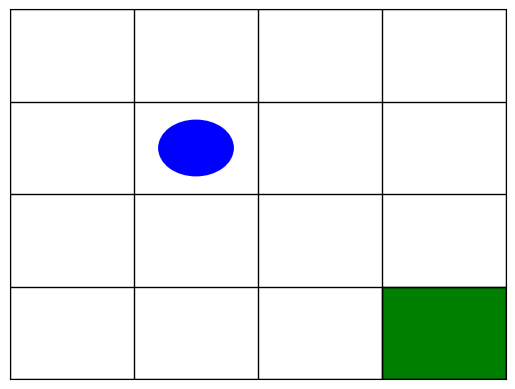

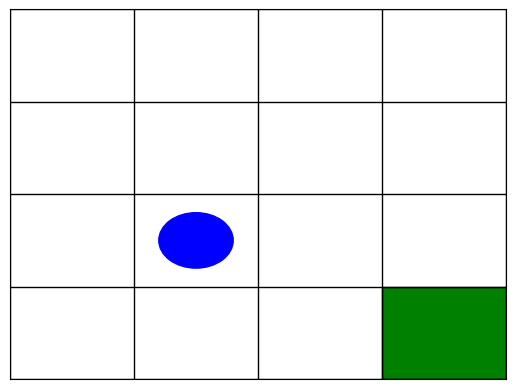

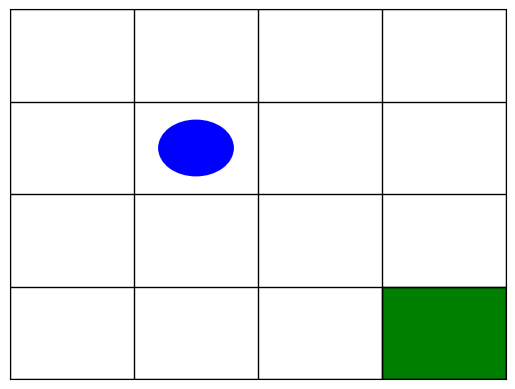

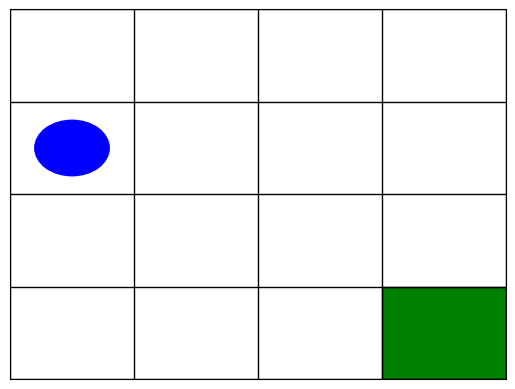

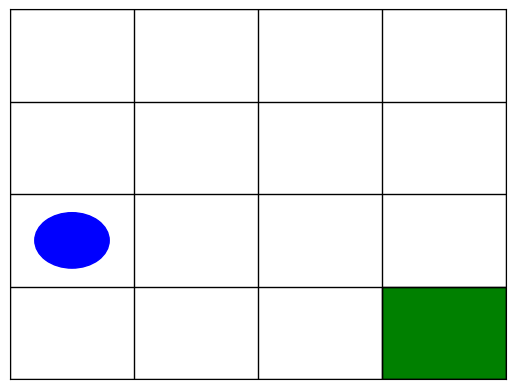

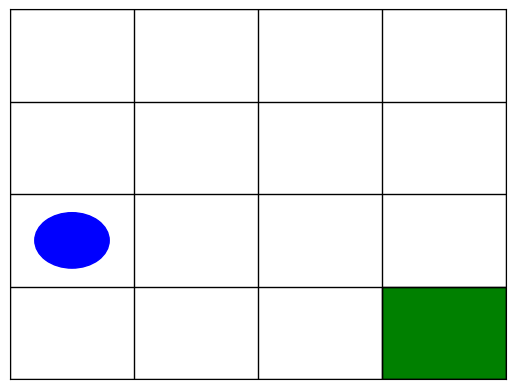

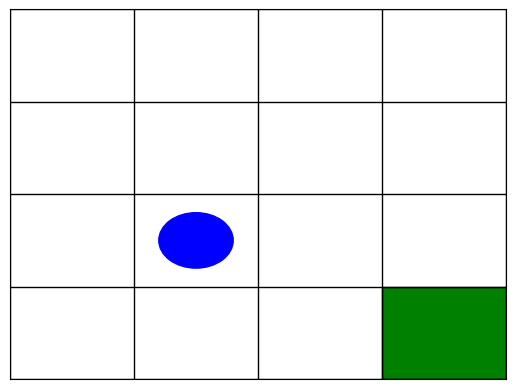

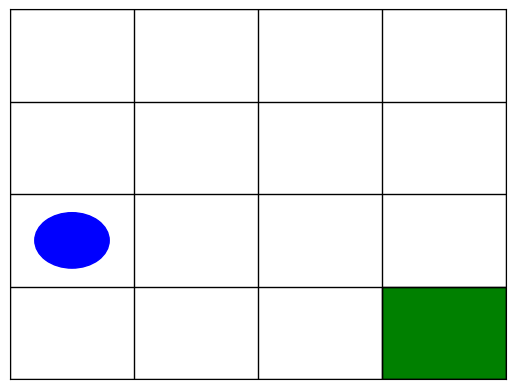

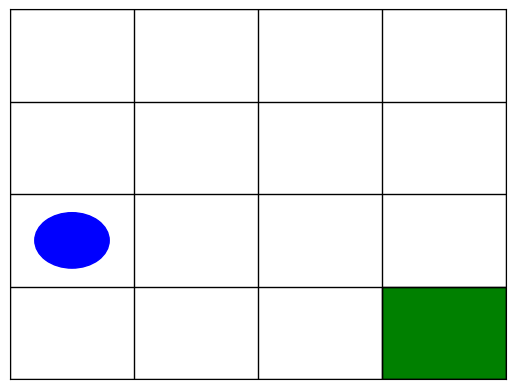

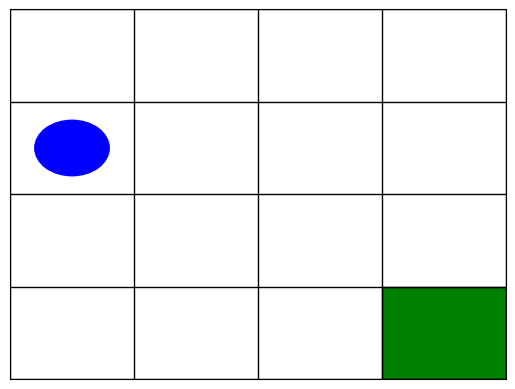

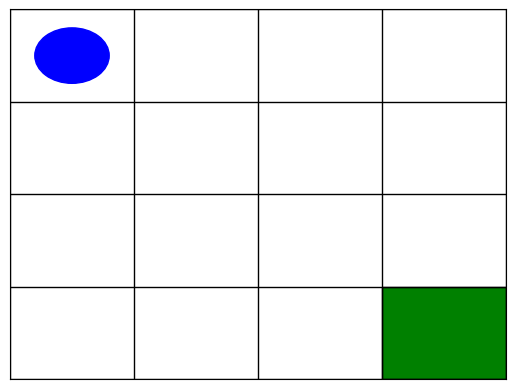

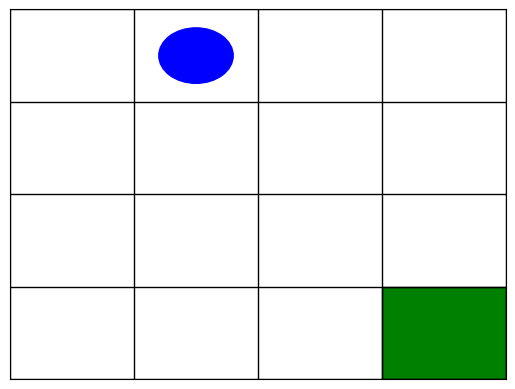

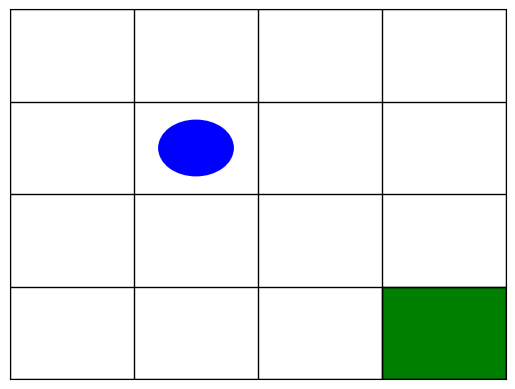

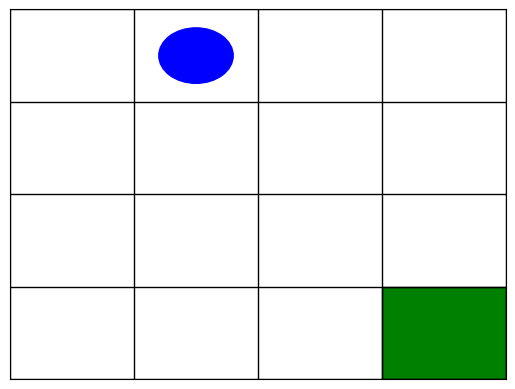

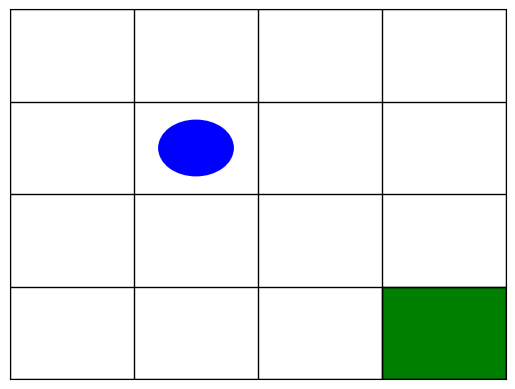

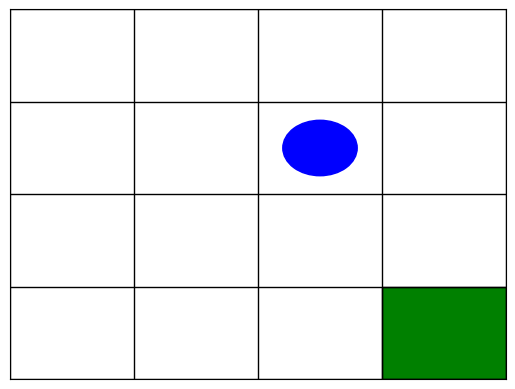

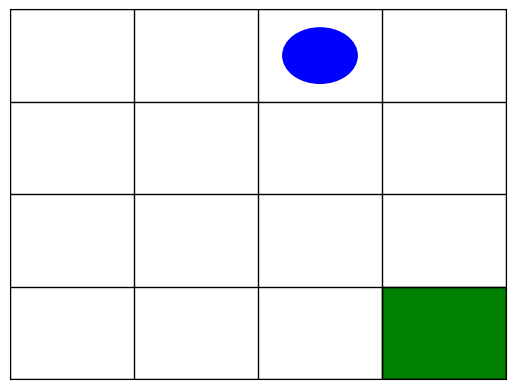

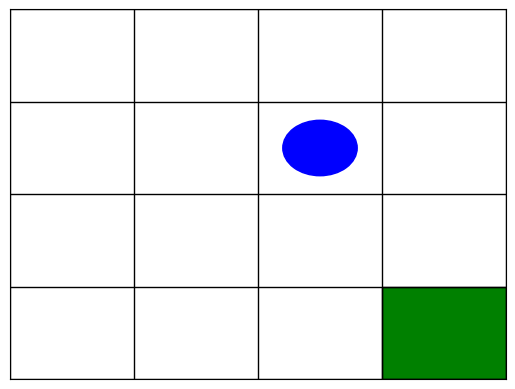

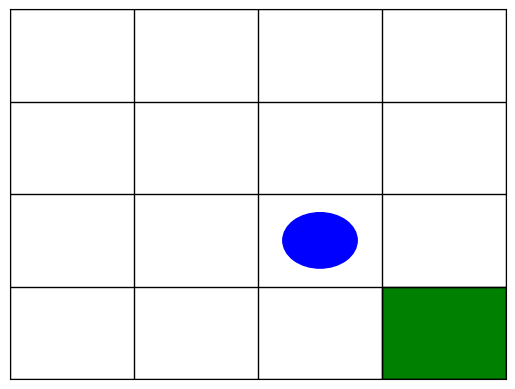

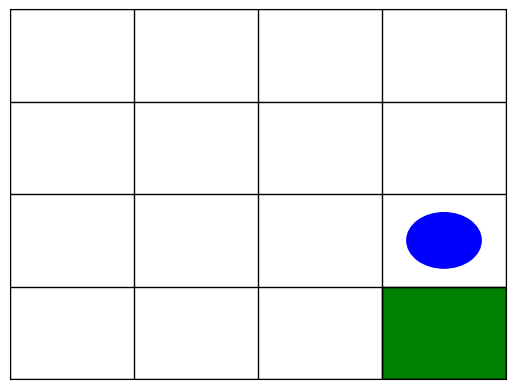

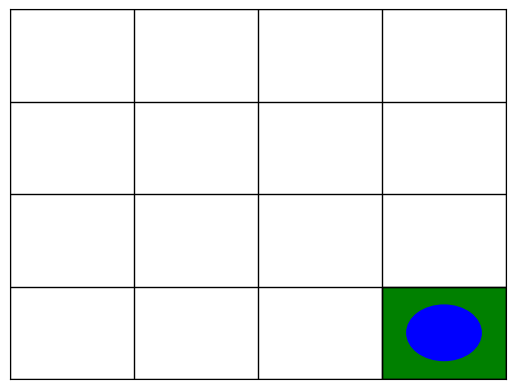

In [24]:
env = SimpleMazeEnv()
state = env.reset()
done = False

print("🔁 Agent moving through maze...")

while not done:
    action = np.random.choice(4)  # Random for demo — replace with SNN action
    next_state, reward, done, _ = env.step(action)

    env.render()
